In [4]:
# Imports
import numpy as np
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import hann, butter, filtfilt, lfilter
from scipy import signal
from matplotlib import use
import matplotlib.pyplot as plt
import time

import matplotlib.figure as mpf

#use('AGG')
output = False

In [5]:
# Constants
fc = 24e9
c = 3e8
ld = c/fc

print("Transmit frequency: " + str(fc))
print("Speed of light: " + str(c))
print("Lambda: " + str(ld))

# Parameter
N_FFT = 1024        # Number of measuring points 
FS = 9000          # Sampling frequency
wFS = FS*2*np.pi    # circular sampling frequency
DT = 1/FS           # Time per sample
TS = DT*N_FFT       # Sampling time

print(DT,TS)

Transmit frequency: 24000000000.0
Speed of light: 300000000.0
Lambda: 0.0125
0.00011111111111111112 0.11377777777777778


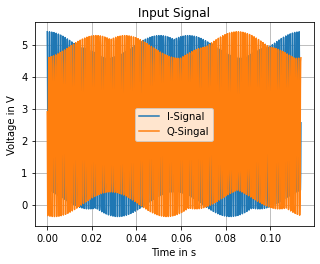

0.11799979209899902


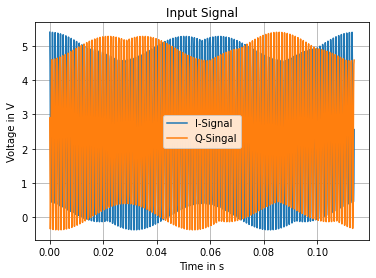

0.1279892921447754


NameError: name 'fig' is not defined

In [6]:

# demo signal
t = np.linspace(0,TS,N_FFT) # time vector

# main Signal
f1 = 1000                   # Frequency for the demo signal
w1 = 2*np.pi*f1             # circular frequency
A1 = 2.500                  # Amplitude
DC = 2.5                    # DC value
I1 = A1*np.cos(w1*t) + DC   # Build the signal

Q1 = A1*-np.sin(w1*t) + DC

# noise 1
# 20kHz
fn1 = 20000                 # Frequency of the noise
wn1 = 2*np.pi*fn1           # circular frequency
An1 = 0.100                 # Amplitude
In1 = An1*np.cos(wn1*t)     # Build the signal

# noise 2
# 50Hz
fn2 = 50
wn2 = 2*np.pi*fn1
An2 = 0.300
In2 = An2*np.cos(wn2*t)

# Signal
I = I1 + In1 + In2 # Signal I
Q = Q1 + In1 + In2 # Signal Q
# y= I + Q1*1j

plt.figure(num=1,figsize=[5,3.74])
time1 = time.time()
# Plot of the Signal
plt.plot(t,I,t,Q)
plt.grid()
plt.title("Input Signal")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.legend(["I-Signal", "Q-Singal"])
if output == True:
    plt.savefig("Input.jpg",dpi=100)
plt.show()
time2 = time.time()
print(time2-time1)

plt.figure(2)
time1 = time.time()
# Plot of the Signal
plt.plot(t,I,t,Q)
plt.grid()
plt.title("Input Signal")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.legend(["I-Signal", "Q-Singal"])
if output == True:
    plt.savefig("Input.png",dpi=100)
plt.show()
time2 = time.time()
print(time2-time1)

fig1 = mpf.Figure(figsize=[500,374],dpi=150)
ax1 = fig.add

2.5


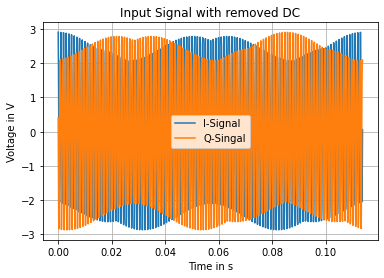

In [ ]:
# Calculate DC
DC_I = 1/N_FFT * np.sum(I)
DC_Q = 1/N_FFT * np.sum(Q)
print(DC)

# remove DC
I = I-DC_I
Q = Q-DC_Q

plt.plot(t,I,t,Q)
plt.grid()
plt.title("Input Signal with removed DC")
plt.xlabel("Time in s")
plt.ylabel("Voltage in V")
plt.legend(["I-Signal", "Q-Singal"])
if output == True:
    plt.savefig("DC_free_input.jpg",dpi=100)
plt.show()

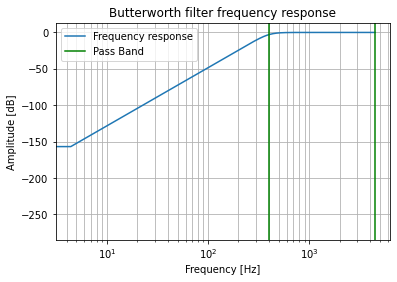

In [ ]:
# create the filter
b,a = butter(4, 400*2*np.pi, btype="highpass", fs=(FS*2*np.pi), output='ba', analog=False)

# frequency response
w,h = signal.freqz(b,a, worN=N_FFT,fs=wFS)
plt.semilogx(w/(2*np.pi),20*np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
#plt.margins(0, 0.1)
plt.axvline(400, color='green') # highpass frequency
plt.axvline(4444, color='green') # lowpass frequency
plt.legend(["Frequency response","Pass Band"])
if output == True:
    plt.savefig("Filter.jpg", dpi=150)
plt.show()

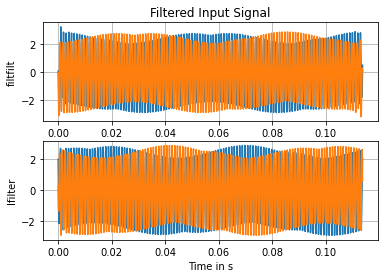

In [ ]:
# filter the signal with lfilter
I_filt1 = lfilter(b,a,I)
Q_filt1 = lfilter(b,a,Q)

# filter the signal with filtfilt
I_filt2 = filtfilt(b,a,I)
Q_filt2 = filtfilt(b,a,Q)

# plot the filtered signals
plt.subplot(211)
plt.plot(t,I_filt2,t,Q_filt2)
plt.title("Filtered Input Signal")
plt.ylabel("filtfilt")
plt.grid()

plt.subplot(212)
plt.plot(t,I_filt1,t,Q_filt1)
plt.xlabel("Time in s")
plt.ylabel("lfilter")
plt.grid()
if output == True:
    plt.savefig("Filter_compared.jpg", dpi=100)
plt.show()


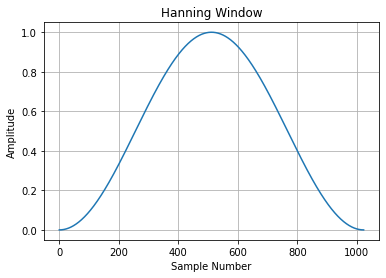

In [ ]:
#create a Window
window = hann(N_FFT, sym=True)
plt.plot(window)
plt.title("Hanning Window")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.grid()
if output == True:
    plt.savefig("Window.jpg",dpi=150)
plt.show()



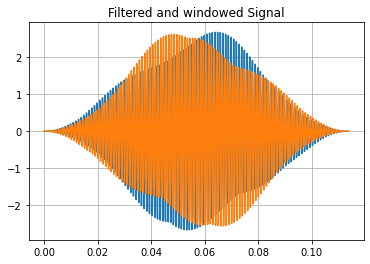

In [ ]:
# apply the Window
I_filt = np.multiply(window,I_filt1)
Q_filt = np.multiply(window,Q_filt1) 
plt.plot(t,I_filt,t,Q_filt)
plt.grid()
plt.title("Filtered and windowed Signal")
if output == True:
    plt.savefig("filtered_windowed.jpg", dpi=100)
plt.show()

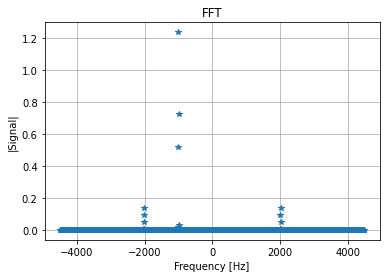

In [ ]:
# Combining I and Q signal
z_t = I_filt + Q_filt * 1j

# Perform the FFT
z_f = fftshift(fft(z_t,norm='forward'))
x_f = fftshift(fftfreq(N_FFT,DT))
z_f_abs = np.abs(z_f)

# Plot the FFT
plt.plot((x_f),z_f_abs,'*')
plt.grid()
plt.title("FFT")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|Signal|")
if output == True:
    plt.savefig("FFT.jpg",dpi=100)
plt.show()

In [ ]:
# Calculate resulting speed -> v = fd/2 * lamda
# z = np.zeros((N_FFT,2))

# z[:,0] = z_f_abs
# z[:,1] = x_f

n_max = np.argmax(z_f_abs)
print("n Max: " + str(n_max))
max_f = x_f[n_max-1]
print("n Max: " + str(n_max) + "; max f:" + str(max_f))
print("end of file")

v = 3.6*max_f/2*ld
print("Simulated Speed: "+ str(v))

n Max: 398
n Max: 398; max f:-1010.7421875
end of file
Simulated Speed: -22.74169921875
